# **Práctica 5: Puntos de interés**

<img src ="https://epigijon.uniovi.es/image/image_gallery?uuid=903ae5c8-b29b-430e-980d-1a19a885c736&groupId=3743853&t=1688576582973" width=300 px>

Este cuaderno desarrolla contenidos prácticos de la asignatura **Visión artificial** del Grado en Ciencia e Ingeniería de Datos.

***

In [2]:
import numpy as np
import skimage
import matplotlib.pyplot as plt
import scipy
import cv2

# Características

La extracción de características en imágenes es un paso crucial en el procesamiento de imágenes y visión por computador. Uno de los tipos de características que se pueden extraer son las esquinas. Las esquinas son puntos distintivos en una imagen que son útiles para tareas como el reconocimiento de objetos, el seguimiento de objetos en movimiento y la reconstrucción tridimensional.

Existen varios algoritmos para la extracción de características. Uno de los más conocidos es el algoritmo Harris Corner Detector. La idea central del detector de Harris es que las esquinas se encuentran en regiones de la imagen donde hay una alta variación en la intensidad en varias direcciones.

> Implementa una función que calcule la función de respuesta de Harris: `def compute_harris_response(im, sigma=3, k=0.04)`

El algoritmo debe realizar las siguientes tareas:

> Determina el gradiente en la dirección vertical y horizontal ($G_x$ y $G_y$) usan el operador FDoG (derivada de la Gaussiana)

> Determina $G_{xx}= (Gx)^2$, $G_{yy} = (Gy)^2$ y $G_{xx} = GxGy$. Suaviza el resultado de estas operaciones según el valor de sigma que se recibe por parámetro.

> Calcula la función de respuesta como $R = det - k * (tr^2)$, donde $det = G_{xx}*G_{yy} - (G_{xy})^2$ y $tr = G_{xx} + G_{yy}$

> Visualiza el resultado para la siguiente imagen de ejemplo


In [3]:
def compute_harris_response(img,sigma=3,k=0.04):
    if img.ndim == 3:
        img = img.mean(axis=-1)
    # Calcula la convolución de la imagen con la derivada del kernel Gaussiano en x
    imx = scipy.ndimage.gaussian_filter(img, (sigma,sigma), (0,1))
    # Calcula la convolución de la imagen con la derivada del kernel Gaussiano en y
    imy = scipy.ndimage.gaussian_filter(img, (sigma,sigma), (1,0))
    
     # Calcula los productos de las derivadas
    Gxx = scipy.ndimage.gaussian_filter(imx**2, sigma)
    Gyy = scipy.ndimage.gaussian_filter(imy**2, sigma)
    Gxy = scipy.ndimage.gaussian_filter(imx * imy, sigma)
    # Calcula el determinante y la traza de la matriz de Harris
    det = Gxx * Gyy - Gxy**2
    tr = Gxx + Gyy
    # Calcula la función de respuesta de Harris
    R = det - k * (tr**2)
    return R

#CALCULA LA FUNCION DE RESPUESTA DE HARRIS, CALCULA UNA IMAGEN DONDE HAY ALTA INTENSIDAD EN LAS ZONAS DONDE TIENE ESQUINAS

In [4]:
!wget http://www.atc.uniovi.es/grado/3va/prac/checkershadow.png

--2024-03-01 11:04:30--  http://www.atc.uniovi.es/grado/3va/prac/checkershadow.png
Resolving www.atc.uniovi.es (www.atc.uniovi.es)... 156.35.151.4
Connecting to www.atc.uniovi.es (www.atc.uniovi.es)|156.35.151.4|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117163 (114K) [image/png]
Saving to: 'checkershadow.png.6'

     0K .......... .......... .......... .......... .......... 43% 1,11M 0s
    50K .......... .......... .......... .......... .......... 87% 2,36M 0s
   100K .......... ....                                       100% 7,08M=0,07s

2024-03-01 11:04:30 (1,67 MB/s) - 'checkershadow.png.6' saved [117163/117163]



In [5]:
!curl www.atc.uniovi.es/grado/3va/prac/checkershadow.png --output checkershadow.jpg
img = skimage.io.imread('checkershadow.jpg')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  114k  100  114k    0     0   750k      0 --:--:-- --:--:-- --:--:--  762k


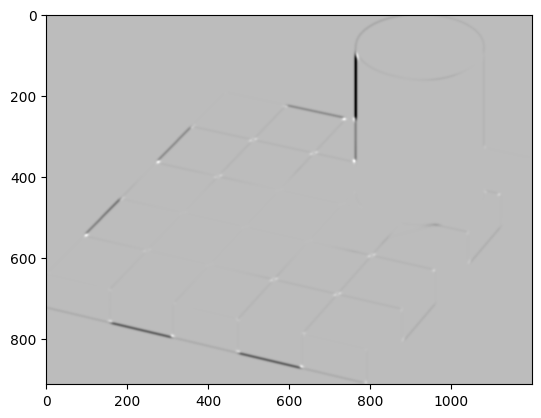

In [6]:
R=compute_harris_response(img,sigma=3)
plt.imshow(R, cmap='gray')
plt.show()

Para determinar la posición de las esquinas hay que buscar los máximos locales en la respuesta. En primer lugar se puede realizar una umbralización:


[[  0 899]
 [  0 900]
 [  0 901]
 ...
 [912 793]
 [912 794]
 [912 795]]


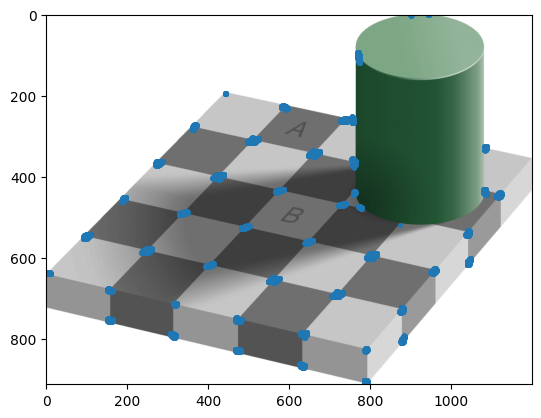

In [7]:

threshold = 0.01
corners = np.argwhere(R > threshold * R.max())

plt.imshow(img, cmap='gray')
corners = np.array(corners)
print(corners)
plt.plot(corners[:, 1], corners[:, 0], '.', markersize=5)
plt.show()

Para una determinada esquina, se obtienen muchos puntos. Para resolver ese problema se debe implementar la función de supresión de no-máximos. La función de supresión de no-máximos, también conocida como NMS (por sus siglas en inglés, Non-Maximum Suppression), es comúnmente utilizada en tareas de detección de objetos en imágenes o vídeos. Su propósito es reducir la redundancia en las detecciones al eliminar las detecciones que se superponen significativamente y retener solo la detección con más confianza, en este caso con mayor valor de la función de respuesta.

> Implementa la función `non_max_suppression(corners, R, distance_threshold)`

El algoritmo debe realizar lo siguiente:

> Ordenar las esquinas por el valor de respuesta: `corners = sorted(corners, key=lambda x: R[x[0], x[1]], reverse=True)`

> Para cada esquina, en orden decreciente de respuesta

> Determinar la distancia a todas las esquinas seleccionadas: `distances = [np.linalg.norm(np.array(corner) - np.array(selected)) for selected in selected_corners]`. Inicialmente `selected_corners` es una lista vacía.

> Si no hay elementos dentro de la distancia seleccionada (`np.count_nonzero(np.array(distances) < distance_threshold) == 0`) se añade a la lista de esquinas seleccionadas.

> Se retornan las esquinas seleccionadas




In [8]:
def non_max_suppression(corners,R,distance_threshold):
    selected_corners=[]
    corners =sorted(corners,key=lambda x: R[x[0],x[1]],reverse=True)
    for corner in corners:
        distances = [np.linalg.norm(np.array(corner) - np.array(selected)) for selected in selected_corners]
    
        if np.count_nonzero(np.array(distances) < distance_threshold) == 0:
            selected_corners.append(corner)
    return selected_corners

[[ 362  760]
 [ 259  736]
 [ 365  277]
 [ 546   99]
 [ 103  769]
 [ 793  312]
 [ 869  631]
 [ 831  474]
 [ 757  159]
 [ 597  798]
 [ 689  725]
 [ 341  667]
 [ 308  517]
 [ 909  790]
 [ 445 1118]
 [ 632  957]
 [ 653  568]
 [ 398  431]
 [ 788  637]
 [ 228  592]
 [ 279  362]
 [ 803  881]
 [ 611 1044]
 [ 454  190]
 [ 585  243]
 [ 540 1041]
 [ 731  877]
 [ 755  473]
 [ 328 1084]
 [ 681  158]
 [ 714  318]
 [ 828  790]
 [ 488  344]
 [ 440  761]
 [ 639    7]
 [ 562  642]
 [ 616  410]
 [ 432  582]
 [ 523  497]
 [ 470  726]
 [   0  900]
 [ 195  443]
 [   0  945]
 [ 519  874]]


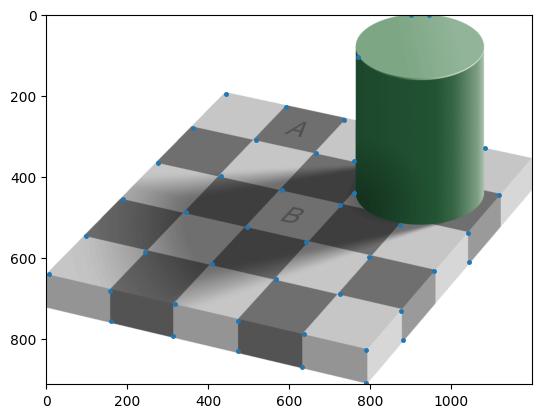

In [9]:
corners=non_max_suppression(corners,R=R,distance_threshold=45)
plt.imshow(img, cmap='gray')
corners = np.array(corners)
print(corners)
plt.plot(corners[:, 1], corners[:, 0], '.', markersize=5)
plt.show()

Las esquinas son consideradas características de interés debido a su invariancia a la rotación y escala, estabilidad estructural, capacidad discriminativa y eficiencia computacional. Estas propiedades únicas hacen que las esquinas destaquen en la detección, seguimiento y reconocimiento de patrones en imágenes, ya que conservan su forma y estructura a través de diferentes orientaciones y escalas, ofrecen estabilidad en regiones con cambios bruscos de intensidad, y son eficientes en términos de procesamiento, siendo esenciales en aplicaciones como la reconstrucción 3D, la realidad aumentada y la identificación de objetos.

> Realiza la detección de esquinas en las siguientes dos imágenes y visualiza los resultados

In [10]:
!wget https://github.com/opencv/opencv_extra/blob/4.x/testdata/stitching/s1.jpg?raw=true -O s1.jpg
!wget https://github.com/opencv/opencv_extra/blob/4.x/testdata/stitching/s2.jpg?raw=true -O s2.jpg


--2024-03-01 11:04:34--  https://github.com/opencv/opencv_extra/blob/4.x/testdata/stitching/s1.jpg?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/opencv/opencv_extra/raw/4.x/testdata/stitching/s1.jpg [following]
--2024-03-01 11:04:34--  https://github.com/opencv/opencv_extra/raw/4.x/testdata/stitching/s1.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/opencv/opencv_extra/4.x/testdata/stitching/s1.jpg [following]
--2024-03-01 11:04:34--  https://raw.githubusercontent.com/opencv/opencv_extra/4.x/testdata/stitching/s1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... con

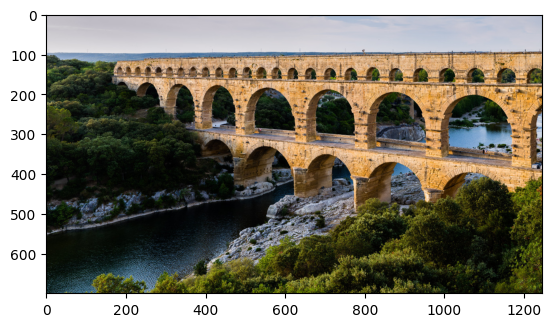

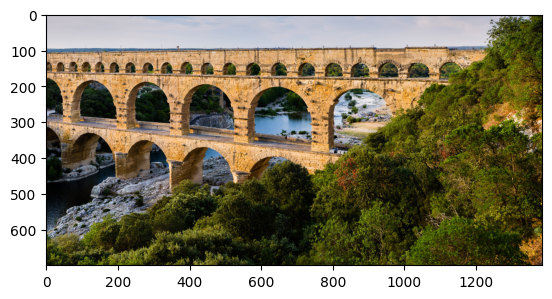

In [11]:
img1 = skimage.io.imread('s1.jpg')
img2 = skimage.io.imread('s2.jpg')
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()


[[ 86 795]
 [ 86 796]
 [ 86 797]
 ...
 [699 863]
 [699 864]
 [699 865]]


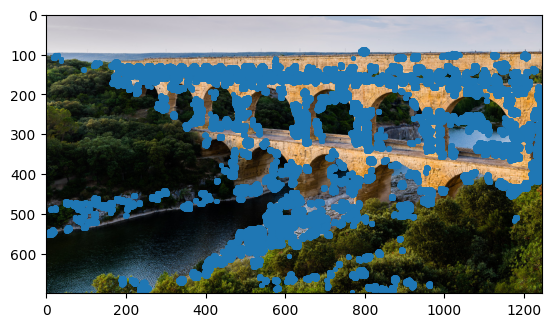

[[ 331 1124]
 [ 468  957]
 [ 343 1239]
 [ 135  283]
 [ 289  622]
 [ 270  451]
 [ 546  605]
 [ 160  629]
 [ 229  287]
 [ 506  555]
 [ 135  503]
 [ 134  370]
 [ 200 1080]
 [ 330 1175]
 [ 285 1234]
 [ 165  893]
 [ 134  580]
 [ 159  676]
 [ 134  231]
 [ 587  514]
 [ 136  766]
 [ 135  435]
 [ 301  771]
 [ 384  610]
 [ 388 1236]
 [ 240 1232]
 [ 194 1141]
 [ 134  185]
 [ 618  431]
 [ 166  956]
 [ 285 1101]
 [ 224  925]
 [ 172  256]
 [ 445 1175]
 [ 135 1077]
 [ 288  989]
 [ 496  628]
 [ 161 1182]
 [ 246  811]
 [ 157  724]
 [ 159  839]
 [ 548  487]
 [ 436  527]
 [ 547  535]
 [ 440  770]
 [ 490  897]
 [ 212  726]
 [ 386  655]
 [ 410  807]
 [ 167 1022]
 [ 451  619]
 [ 214  474]
 [ 440  995]
 [ 270 1162]
 [ 247  378]
 [ 321  507]
 [ 482  357]
 [  92  797]
 [ 523  674]
 [ 509  759]
 [ 402 1054]
 [ 420 1137]
 [ 335  964]
 [ 233  686]
 [ 364  815]
 [ 346  579]
 [ 379  746]
 [ 403  466]
 [ 125 1149]
 [ 464  125]
 [ 690  843]
 [ 293  682]
 [ 651  400]
 [ 427  580]
 [ 400  924]
 [ 550    5]
 [ 270  947]

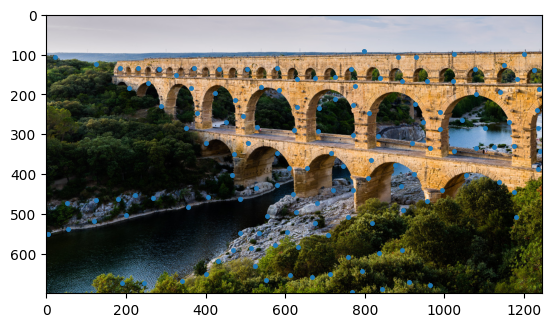

In [15]:
R=compute_harris_response(img1,sigma=3)

threshold = 0.01
corners1 = np.argwhere(R > threshold * R.max())

plt.imshow(img1, cmap='gray')
corners = np.array(corners1)
print(corners1)
plt.plot(corners1[:, 1], corners1[:, 0], '.', markersize=5)
plt.show()
corners1=non_max_suppression(corners1,R=R,distance_threshold=45)
plt.imshow(img1, cmap='gray')
corners1 = np.array(corners1)
print(corners1)
plt.plot(corners1[:, 1], corners1[:, 0], '.', markersize=5)
plt.show()


[[   0 1294]
 [   0 1295]
 [   0 1296]
 ...
 [ 699 1352]
 [ 699 1353]
 [ 699 1354]]


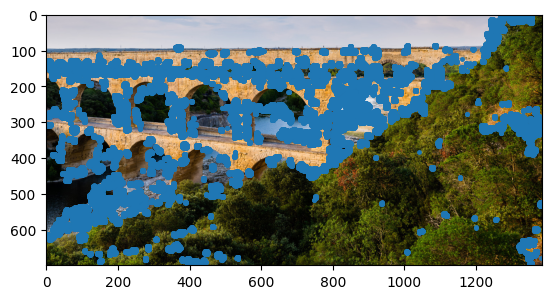

[[ 238  855]
 [ 468  529]
 [ 331  695]
 [ 343  810]
 [ 289  193]
 [ 270   22]
 [ 546  176]
 [ 281  829]
 [ 160  200]
 [ 506  126]
 [ 259  895]
 [ 135   74]
 [ 200  651]
 [ 158  924]
 [ 330  747]
 [ 134  151]
 [ 165  464]
 [ 172  980]
 [ 159  247]
 [  12 1347]
 [ 343 1351]
 [ 587   85]
 [ 135  338]
 [ 301  343]
 [ 384  181]
 [ 384  830]
 [ 300 1374]
 [ 241  804]
 [ 300 1309]
 [ 134    7]
 [ 194  712]
 [ 171 1068]
 [ 166  527]
 [ 165  848]
 [  25 1260]
 [ 285  672]
 [ 445  747]
 [ 224  497]
 [ 135  648]
 [ 496  199]
 [ 288  560]
 [ 161  753]
 [ 594   31]
 [ 246  382]
 [ 157  295]
 [ 159  411]
 [ 548   58]
 [ 436   98]
 [ 529 1384]
 [ 440  341]
 [ 547  106]
 [  96  913]
 [ 386  226]
 [ 490  468]
 [ 212  297]
 [ 300  785]
 [ 167  593]
 [ 410  378]
 [ 299  917]
 [ 440  566]
 [ 451  190]
 [ 214   45]
 [ 139 1020]
 [ 420  709]
 [ 270  734]
 [ 321   78]
 [  89 1245]
 [  92  368]
 [ 523  245]
 [ 509  330]
 [ 312 1265]
 [ 275  968]
 [ 402  625]
 [ 649 1324]
 [ 379  317]
 [ 233  257]
 [ 335  535]

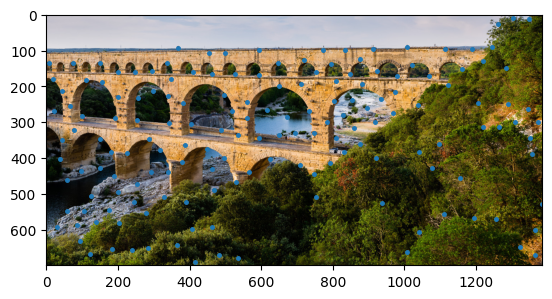

In [16]:
R=compute_harris_response(img2,sigma=3)
threshold = 0.01
corners2 = np.argwhere(R > threshold * R.max())

plt.imshow(img2, cmap='gray')
corners2 = np.array(corners2)
print(corners2)
plt.plot(corners2[:, 1], corners2[:, 0], '.', markersize=5)
plt.show()
corners2=non_max_suppression(corners2,R=R,distance_threshold=45)
plt.imshow(img2, cmap='gray')
corners2 = np.array(corners2)
print(corners2)
plt.plot(corners2[:, 1], corners2[:, 0], '.', markersize=5)
plt.show()

Observa que las esquinas aparecen repetidas en ambas vistas. Idealmente esto debería permitir alinear ambas imágenes y crear una única imagen combinación de ambas.

> Implementa una función que extraiga descriptores de cada esquina. Esta función obtiene un vector con los valores de intensidad alrededor de cada coordenada de esquina. Aquellas esquinas que estén muy cerca del borde se pueden ignorar.

> Implementa una función que determine correspondencias entre los descriptores de ambas imágenes para encontrar coincidencias. Para la comparación se debe utilizar la correlación cruzada normalizada.

> Muestra las resultados utilizando la función `skimage.feature.plot_matches`

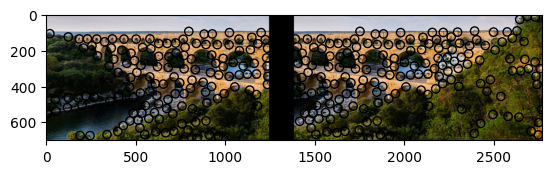

In [36]:
import numpy as np
import cv2

from skimage.feature import plot_matches
import matplotlib.pyplot as plt

def extract_descriptors(image, corners, patch_size=2):
    descriptors = []
    
    for corner in corners:
        y, x = corner
        if x - patch_size//2 >= 0 and y - patch_size//2 >= 0 and x + patch_size//2 < image.shape[1] and y + patch_size//2 < image.shape[0]:
            patch = image[y - patch_size//2:y + patch_size//2 + 1, x - patch_size//2:x + patch_size//2 + 1]
            descriptor = patch.flatten()
            descriptors.append(descriptor)
    
    return np.array(descriptors)

def find_correspondences(desc1, desc2, threshold=45):
    matches = []

    for i in range(desc1.shape[0]):
        # Compute normalized cross-correlation between descriptors
        correlation = np.dot(desc1[i], desc2.T) / (np.linalg.norm(desc1[i]) * np.linalg.norm(desc2, axis=1))
        
        # Find the best match
        match_index = np.argmax(correlation)
        match_value = correlation[match_index]
        
        # Check if the match passes the threshold
        if match_value > threshold:
            matches.append((i, match_index))
    
    return matches

# Assuming img1 and img2 are your two images
# Assuming corners1 and corners2 are the corner coordinates obtained from Harris corner detection for each image

# Extract descriptors for each image
desc1 = extract_descriptors(img1, corners1)
desc2 = extract_descriptors(img2, corners2)

# Find correspondences between descriptors
correspondences = find_correspondences(desc1, desc2)
correspondences = np.array(correspondences)

# # Convert corners1 and corners2 to 2D arrays
src_pts = np.array(corners1).reshape(-1, 2)
dst_pts = np.array(corners2).reshape(-1, 2)

# Visualize correspondences using skimage's plot_matches
fig, ax = plt.subplots()
plot_matches(ax, img1, img2, src_pts, dst_pts, matches=correspondences)
plt.show()

> Utiliza la función `skimage.feature.match_descriptors` y observa las diferencias.

AttributeError: 'NoneType' object has no attribute 'shape'

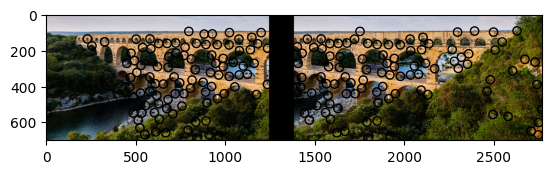

In [37]:
from skimage.feature import match_descriptors
# Extract descriptors for each image
desc1 = extract_descriptors(img1, corners1)
desc2 = extract_descriptors(img2, corners2)

# Find correspondences between descriptors using match_descriptors
matches = match_descriptors(desc1, desc2)
# Convert matches to point correspondences
src_pts = np.array([corners1[i] for i, _ in matches])
dst_pts = np.array([corners2[j] for _, j in matches])

# Visualize correspondences using skimage's plot_matches
fig, ax = plt.subplots()
plot_matches(ax, img1, img2, src_pts, dst_pts, matches=None)  # Note: matches=None as we've already provided src_pts and dst_pts
plt.show()

> Extrae descriptores con alguna de las opciones de la biblioteca skimage, busca correspondencias y muestra los resultados.